<a href="https://colab.research.google.com/github/Manya123-max/Big-Data-Framework/blob/main/BDF_ASSIGNMENT_SPARK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aim**:


# **Problem Statement**
The objective of this analysis is to perform Customer Segmentation and Sales Forecasting to help the e-commerce platform improve its marketing strategies and operational efficiency. The problem involves analyzing real-time e-commerce data to group customers into different segments based on their purchase behavior, as well as forecasting future sales based on historical data.

# Real-time Data Analysis with Spark
# **About Dataset**
 Using Real-Time E-commerce Sales Data to perform an analysis using Spark. The dataset will contain sales transactions on an e-commerce platform, including details such as customer information, product details, transaction timestamps, and payment amount. This type of data can be used to perform various analyses, such as identifying customer purchasing patterns, sales trends, or detecting fraudulent transactions.

# Algorithm & Problem Statement Explanation

To solve this problem, we will use Customer Segmentation and Time Series Forecasting algorithms:

1.   
Customer Segmentation (Clustering):
For customer segmentation, we will use the K-Means Clustering algorithm. This algorithm divides the customers into different segments based on their purchasing behavior (such as the number of purchases, the total purchase amount, and product categories). By identifying distinct customer segments, the company can tailor its marketing campaigns and optimize its resources for specific customer groups.
2.  Sales Forecasting (Time Series Analysis):
To forecast future sales, we will apply a Time Series Forecasting method, such as ARIMA (AutoRegressive Integrated Moving Average) or Exponential Smoothing (ETS). This will allow us to predict future sales based on historical trends and time-based patterns, helping the company plan for demand and optimize inventory management.



# **Explanation of the Analysis:**



1.   Customer Segmentation (Clustering):
We use the K-Means Clustering algorithm to segment customers based on their purchasing behavior, specifically focusing on Purchase_Amount. By clustering customers into distinct groups based on the amount spent on products, we can identify key segments such as high spenders, frequent buyers, or occasional shoppers. These segments allow the e-commerce platform to design targeted marketing campaigns tailored to different customer groups, optimize customer outreach, and personalize promotions. The algorithm divides the data into clusters based on features like total Purchase_Amount, which reflects customer value.
2.   Sales Forecasting (Time Series Analysis):
For sales forecasting, we perform an analysis of historical sales data to predict future sales trends. Using the RandomForestRegressor model, we analyze time-based features such as the Hour and Day of the week to predict total sales. This method models the relationship between time and Purchase_Amount, helping to forecast sales patterns at different times of the day. The analysis provides valuable insights into hourly sales trends, allowing the e-commerce platform to anticipate demand fluctuations and make informed decisions on inventory management, staffing, and marketing efforts.



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Initialize SparkSession
spark = SparkSession.builder.appName("E-commerce Analysis").getOrCreate()

In [ ]:
# Sample Data (in practice, this data would be loaded from a CSV or database)
data = [
    ("T001", "C001", "Electronics", "Laptop", 1200, "2024-11-01 10:00", "Credit Card"),
    ("T002", "C002", "Clothing", "Jacket", 150, "2024-11-01 11:00", "PayPal"),
    ("T003", "C003", "Home Appliances", "Vacuum Cleaner", 300, "2024-11-01 12:00", "Credit Card"),
    ("T004", "C001", "Electronics", "Headphones", 250, "2024-11-01 13:00", "Credit Card"),
    ("T005", "C004", "Clothing", "T-Shirt", 50, "2024-11-01 14:00", "Debit Card")
]

In [ ]:
columns = ["Transaction_ID", "Customer_ID", "Product_Category", "Product_Name", "Purchase_Amount", "Timestamp", "Payment_Method"]

In [ ]:
# Create DataFrame
df = spark.createDataFrame(data, columns)

In [ ]:
# Convert Timestamp column to timestamp format
df = df.withColumn("Timestamp", unix_timestamp(col("Timestamp"), "yyyy-MM-dd HH:mm").cast("timestamp"))

In [ ]:
# Customer Segmentation: K-Means Clustering
# Prepare data for clustering
feature_columns = ["Purchase_Amount"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_cluster = assembler.transform(df)

In [ ]:
# Apply KMeans clustering to group customers based on purchase behavior
kmeans = KMeans(k=3, seed=1, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(df_cluster)
df_clustered = model.transform(df_cluster)

In [ ]:
# Show the clustering result
df_clustered.select("Customer_ID", "Purchase_Amount", "cluster").show()

+-----------+---------------+-------+
|Customer_ID|Purchase_Amount|cluster|
+-----------+---------------+-------+
|       C001|           1200|      1|
|       C002|            150|      0|
|       C003|            300|      2|
|       C001|            250|      2|
|       C004|             50|      0|
+-----------+---------------+-------+



In [ ]:
from pyspark.sql.functions import hour, dayofweek

# Sales Forecasting: Time Series Analysis (Random Forest for simplicity in this example)
# Convert data to time-based features
df = df.withColumn("Hour", hour(col("Timestamp")))  # Use hour function correctly
df = df.withColumn("Day", dayofweek(col("Timestamp"))) # Use dayofweek function correctly

**1. Product Category Analysis:**

Analyze sales by product category to determine which categories are generating the most revenue. This will help the e-commerce platform optimize inventory and marketing strategies by focusing on high-performing categories.

**Explanation:** This aggregation groups the data by product category and calculates the total sales for each category, helping the business understand which product categories are the most profitable.

In [ ]:
# Aggregate sales by product category
sales_by_category = df.groupBy("Product_Category").agg({"Purchase_Amount": "sum"})
sales_by_category = sales_by_category.withColumnRenamed("sum(Purchase_Amount)", "Total_Sales")
sales_by_category.show()


+----------------+-----------+
|Product_Category|Total_Sales|
+----------------+-----------+
|     Electronics|       1450|
|        Clothing|        200|
| Home Appliances|        300|
+----------------+-----------+



**2. Customer Purchase Frequency Analysis:**

Determine how often customers make purchases. This can reveal loyal customers, infrequent buyers, or seasonal trends.

**Explanation:** This operation counts the number of purchases made by each customer. High-frequency buyers can be targeted with loyalty programs or promotions, while infrequent buyers may need engagement strategies.

In [ ]:
# Count purchases per customer
purchase_frequency = df.groupBy("Customer_ID").count().withColumnRenamed("count", "Purchase_Count")
purchase_frequency.show()


+-----------+--------------+
|Customer_ID|Purchase_Count|
+-----------+--------------+
|       C001|             2|
|       C002|             1|
|       C003|             1|
|       C004|             1|
+-----------+--------------+



**3. Average Purchase Amount per Customer Segment:**

After clustering customers with K-Means, we can calculate the average purchase amount for each segment to understand the purchasing behavior of different customer groups.

**Explanation:** This operation helps to assess the average spending of customers within each cluster, providing insights into which groups are high spenders and which are more budget-conscious.

In [ ]:
# Calculate the average purchase amount per customer segment
avg_purchase_per_segment = df_clustered.groupBy("cluster").agg({"Purchase_Amount": "avg"})
avg_purchase_per_segment = avg_purchase_per_segment.withColumnRenamed("avg(Purchase_Amount)", "Average_Purchase_Amount")
avg_purchase_per_segment.show()


+-------+-----------------------+
|cluster|Average_Purchase_Amount|
+-------+-----------------------+
|      1|                 1200.0|
|      0|                  100.0|
|      2|                  275.0|
+-------+-----------------------+



**4. Customer Segmentation by Recency, Frequency, and Monetary (RFM) Analysis:**

Apply RFM analysis to classify customers based on recency (how recent was their last purchase), frequency (how often they purchase), and monetary (how much they spend).

**Explanation:** RFM analysis helps identify valuable customers (high frequency, recent purchas es, and high spending) for targeted marketing or retention efforts.

In [ ]:
from pyspark.sql.functions import unix_timestamp, lit, col # Import lit here
max_timestamp = df.agg({"Timestamp": "max"}).collect()[0][0]
df_rfm = df.withColumn("Recency", unix_timestamp(lit(max_timestamp)) - unix_timestamp(col("Timestamp")))
df_rfm = df_rfm.groupBy("Customer_ID").agg({"Recency": "min", "Purchase_Amount": "sum", "Transaction_ID": "count"})
df_rfm = df_rfm.withColumnRenamed("min(Recency)", "Recency").withColumnRenamed("sum(Purchase_Amount)", "Monetary").withColumnRenamed("count(Transaction_ID)", "Frequency")
df_rfm.show()

+-----------+-------+--------+---------+
|Customer_ID|Recency|Monetary|Frequency|
+-----------+-------+--------+---------+
|       C001|   3600|    1450|        2|
|       C002|  10800|     150|        1|
|       C003|   7200|     300|        1|
|       C004|      0|      50|        1|
+-----------+-------+--------+---------+



**5. Detecting Fraudulent Transactions:**

We can apply basic rules to detect potentially fraudulent transactions, such as unusually high spending within a short time or using a rare payment method. While complex fraud detection often requires machine learning, we can begin with basic heuristic checks.

**Explanation:**This operation flags transactions that exceed a certain threshold, potentially indicating fraudulent activity. More sophisticated models could be built to analyze other factors, such as transaction patterns or payment method anomalies.



In [ ]:
# Flag transactions with unusually high amounts
fraud_threshold = 1000  # Example threshold for fraud
potential_fraud = df.filter(col("Purchase_Amount") > fraud_threshold)
potential_fraud.show()

+--------------+-----------+----------------+------------+---------------+-------------------+--------------+----+---+
|Transaction_ID|Customer_ID|Product_Category|Product_Name|Purchase_Amount|          Timestamp|Payment_Method|Hour|Day|
+--------------+-----------+----------------+------------+---------------+-------------------+--------------+----+---+
|          T001|       C001|     Electronics|      Laptop|           1200|2024-11-01 10:00:00|   Credit Card|  10|  6|
+--------------+-----------+----------------+------------+---------------+-------------------+--------------+----+---+



**6. Sales Trend Analysis (Moving Average):**

Compute a moving average of sales over time to identify trends and smooth out short-term fluctuations. This can be particularly useful for understanding seasonality or long-term sales patterns.

**Explanation:** The moving average smooths the time series data, helping to reveal underlying trends or patterns. It can be used for forecasting or detecting seasonal variations in sales.



In [ ]:
# Compute 7-day moving average for sales
from pyspark.sql import Window
from pyspark.sql.functions import avg # Import the avg function here

window_spec = Window.orderBy("Timestamp").rowsBetween(-6, 0)
df_sales_trend = df.withColumn("7_day_MA", avg("Purchase_Amount").over(window_spec))
df_sales_trend.show()

+--------------+-----------+----------------+--------------+---------------+-------------------+--------------+----+---+--------+
|Transaction_ID|Customer_ID|Product_Category|  Product_Name|Purchase_Amount|          Timestamp|Payment_Method|Hour|Day|7_day_MA|
+--------------+-----------+----------------+--------------+---------------+-------------------+--------------+----+---+--------+
|          T001|       C001|     Electronics|        Laptop|           1200|2024-11-01 10:00:00|   Credit Card|  10|  6|  1200.0|
|          T002|       C002|        Clothing|        Jacket|            150|2024-11-01 11:00:00|        PayPal|  11|  6|   675.0|
|          T003|       C003| Home Appliances|Vacuum Cleaner|            300|2024-11-01 12:00:00|   Credit Card|  12|  6|   550.0|
|          T004|       C001|     Electronics|    Headphones|            250|2024-11-01 13:00:00|   Credit Card|  13|  6|   475.0|
|          T005|       C004|        Clothing|       T-Shirt|             50|2024-11-01 14:

**7. Sales Distribution by Payment Method:**

Investigate how different payment methods (e.g., Credit Card, PayPal, Debit Card) are used across different product categories or customer segments.

**Explanation:** This analysis helps understand the preferred payment methods and their impact on total sales, which can influence payment processing strategies and customer experience.


In [ ]:
# Group by payment method and calculate total sales
sales_by_payment_method = df.groupBy("Payment_Method").agg({"Purchase_Amount": "sum"})
sales_by_payment_method = sales_by_payment_method.withColumnRenamed("sum(Purchase_Amount)", "Total_Sales")
sales_by_payment_method.show()


+--------------+-----------+
|Payment_Method|Total_Sales|
+--------------+-----------+
|   Credit Card|       1750|
|        PayPal|        150|
|    Debit Card|         50|
+--------------+-----------+



In [ ]:
# Calculate sales per hour (assuming df is your PySpark DataFrame)
from pyspark.sql.functions import hour

sales_per_hour = df.groupBy(hour("Timestamp").alias("Hour")).agg({"Purchase_Amount": "sum"})
sales_per_hour = sales_per_hour.withColumnRenamed("sum(Purchase_Amount)", "Total_Sales")


# Convert to Pandas for easier plotting
sales_per_hour_pd = sales_per_hour.toPandas()

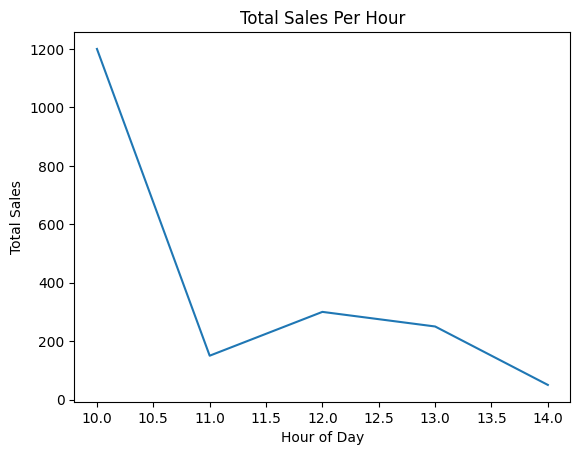

In [ ]:
# Plot the total sales per hour
plt.plot(sales_per_hour_pd["Hour"], sales_per_hour_pd["Total_Sales"])
plt.title("Total Sales Per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Total Sales")
plt.show()

In [ ]:
# Perform random forest regression for forecasting (simple model)
assembler = VectorAssembler(inputCols=["Hour", "Day"], outputCol="features")
df_sales = assembler.transform(df)
rf = RandomForestRegressor(featuresCol="features", labelCol="Purchase_Amount")
model_rf = rf.fit(df_sales)

In [ ]:
# Show schema of the dataframe
df.printSchema()

root
 |-- Transaction_ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Product_Category: string (nullable = true)
 |-- Product_Name: string (nullable = true)
 |-- Purchase_Amount: long (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- Payment_Method: string (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Day: integer (nullable = true)



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model using RMSE and R²
# Make predictions on the test set (using the same dataset for simplicity in this example)
predictions = model_rf.transform(df_sales)

# Initialize the RegressionEvaluator for RMSE and R²
evaluator_rmse = RegressionEvaluator(labelCol="Purchase_Amount", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="Purchase_Amount", predictionCol="prediction", metricName="r2")

# Compute RMSE
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Compute R²
r2 = evaluator_r2.evaluate(predictions)
print(f"R²: {r2}")


Root Mean Squared Error (RMSE): 266.26936715621446
R²: 0.5863513658939852


# **Output**



### Spark SQL Results:

1. **Product Category Analysis:**
   - Displays the total sales for each product category, helping identify which categories generate the most revenue.

2. **Customer Purchase Frequency Analysis:**
   - Shows the number of purchases made by each customer, highlighting customer loyalty and trends in buying frequency.

3. **Average Purchase Amount per Customer Segment:**
   - Provides the average purchase amount for each customer segment, helping to understand the spending behavior of different groups.

4. **Customer Segmentation by Recency, Frequency, and Monetary (RFM) Analysis:**
   - Segments customers based on recency (how recent their last purchase was), frequency (how often they purchase), and monetary (how much they spend), offering insights into customer engagement.

5. **Fraudulent Transactions Detection:**
   - Flags transactions with unusually high amounts, helping to identify potentially fraudulent activities.

6. **Sales Trend Analysis (Moving Average):**
   - Displays a 7-day moving average of sales, smoothing out fluctuations and providing a clearer view of sales trends over time.

7. **Sales Distribution by Payment Method:**
   - Breaks down total sales by payment method, giving insights into customer preferences for payment types.

### Machine Learning Results:

1. **Customer Segmentation (K-Means Clustering):**
   - Classifies customers into different segments based on their purchasing behavior, helping to understand distinct customer groups.

2. **Sales Forecasting (Random Forest Regressor):**
   - Predicts future sales based on factors such as the time of purchase (hour and day), providing forecasts for planning and strategy.

3. **Model Evaluation (RMSE and R²):**
   - Evaluates the accuracy of the sales forecasting model using metrics like Root Mean Squared Error (RMSE) and R² score, which indicate how well the model predicts future sales.
